# 1. Import yfinance, Pandas, NumPy, and Matplotlib

In [10]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 2. Download the Data of "AAPL" (1 year daily)

In [11]:
Ticker="AAPL"
data = yf.download(Ticker, period='1y')
data = data[['Close']] # We are only interested in closing data.

/tmp/ipython-input-569572768.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(Ticker, period='1y')
[*********************100%***********************]  1 of 1 completed


# 3. Calculate RSI
First, compute daily price changes:  
$\Delta p_t = \text{Close}_t - \text{Close}_{t-1}$

Separate gains/losses:  
- If $\Delta p_t > 0$: Gain = $\Delta p_t$, Loss = 0  
- If $\Delta p_t < 0$: Gain = 0, Loss = $-\Delta p_t$  
- Else: Both = 0  

Compute smoothed averages (Wilder's method, N=14):  
- Initial (first 14 days): Simple average of gains/losses.  
- Subsequent days:  
  $\text{Avg Gain}_t = \frac{\text{Avg Gain}_{t-1} \times 13 + \text{Gain}_t}{14}$
  (Same for Avg Loss.)  

Relative Strength:  
$\text{RS} = \frac{\text{Avg Gain}}{\text{Avg Loss}} \quad (\text{handle division by zero: RS=0 if Loss=0})$

RSI:  
$\text{RSI}_t = 100 - \frac{100}{1 + \text{RS}}$

In [ ]:
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0).rolling(window=14).mean()
loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
rs = np.where(loss == 0,
              np.where(gain > 0, np.inf, 0),  # RS=infinity if gains; 0 if flat
              gain / loss)
rsi = 100 - (100 / (1 + rs))
rsi = np.where(np.isinf(rs), 100, rsi)  # Force RSI=100 on infinity
data['RSI'] = rsi

# 4. Generate Signals
- RSI < 30 -> Buy
- RSI > 70 -> Sell

In [13]:
data['Signal'] = 0
data.loc[data['RSI'] < 30, 'Signal'] = 1   # BUY
data.loc[data['RSI'] > 70, 'Signal'] = -1  # SELL
data_plot = data.dropna() # Drop the NaN to make the diagram clear

# 5. Plot the Diagram

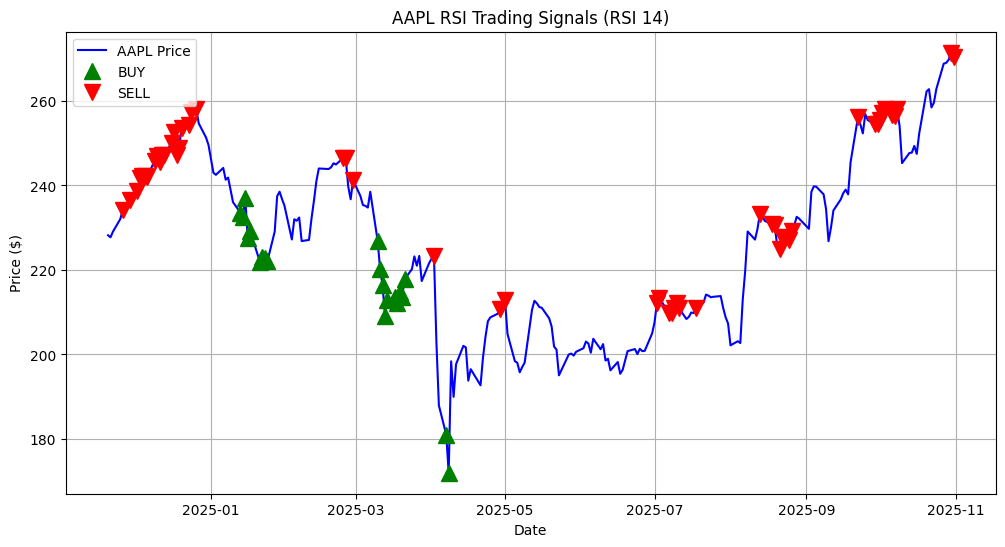

In [14]:
plt.figure(figsize=(12,6))
plt.plot(data_plot['Close'], label='AAPL Price', color='blue')
plt.plot(data_plot[data_plot['Signal']==1].index, data_plot['Close'][data_plot['Signal']==1], '^', markersize=12, color='green', label='BUY')
plt.plot(data_plot[data_plot['Signal']==-1].index, data_plot['Close'][data_plot['Signal']==-1], 'v', markersize=12, color='red', label='SELL')
plt.title('AAPL RSI Trading Signals (RSI 14)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid()
plt.show()

# 6. Statistics
- Count the number of signals generated.

In [15]:
buys = len(data_plot[data_plot['Signal']==1])
sells = len(data_plot[data_plot['Signal']==-1])
print(f"Generated {buys} BUY signals and {sells} SELL signals.")

Generated 21 BUY signals and 52 SELL signals.
